In [774]:
!cd Pic_t && rm -rf ./*

In [702]:
import numpy as np
from scipy.stats import norm

from tqdm import trange
from tqdm import tqdm
from time import sleep
#from tqdm.notebook import tqdm_notebook
#from rich.progress import Progress
#from rich.progress import track
from IPython.display import Image

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

/tmp/ipykernel_408/1320758607.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [1109]:
m=3.1/100 
G = 3.086*10**13/233  
n100=100
R_cl=4*10**10 #  R_claster in km

T_e=1/(25.5*np.log10(n100/2))*np.sqrt(n100*R_cl**(3)/(G*m))
a=0.005 * 3.086*10**13 # a = 0.01 pc
e=0.995 # Eccentricity
# R_e = (((T_e/(1000*2*2*np.pi))**2)*G*500)**(1/3)
v_e= np.sqrt(G* (30+30+2*100*m)*(1-e)/(a*(1+e))) # velocity in apoapsis
# np.sqrt(G*500/(4*R_e))
#R_e,T_e,v_e,2*np.pi*R_e/(T_e/1000)
print(f"a= {a:.3}, e= {e:.3f}, T_e= {T_e:.2}, V_e= {v_e:.2}")



a= 1.54e+11, e= 0.995, T_e= 2.9e+10, V_e= 0.14


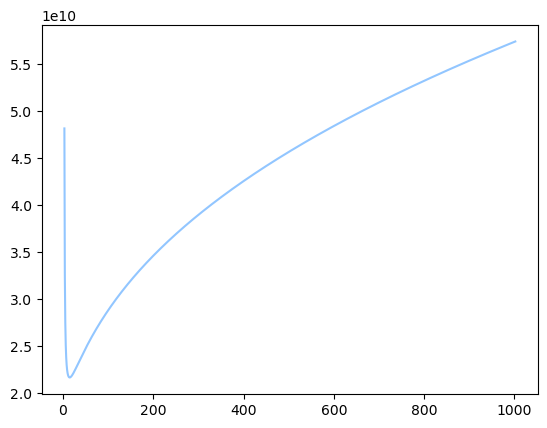

In [573]:
c=R_cl**(3)/(G*m)
x=np.linspace(3,1002,1000)
y=1/(25.5*np.log10(x/2))*np.sqrt(x*c)
plt.plot(x,y)
plt.show()

In [1142]:
a*(1-e)/10**13

7.715000000000007e-05

In [1117]:
"""
Create Your Own N-body Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz
Simulate orbits of stars interacting due to gravity
Code calculates pairwise forces according to Newton's Law of Gravity
"""
""" N-body simulation """
# Simulation parameters
N = 202  # Number of particles
N_c1=100
t = 0      # current time of the simulation
tEnd = T_e # time at which simulation ends
dt = 10**5   # timestep 000000
softening = 1.e7    # softening length
softening_M = 1.e7
# 1 pc = 3.08*10**13 km
G = 3.086*10**13/233  # approx 4.3009172706*3.086*10**10 # Newton's Gravitational Constant # km⋅M⊙−1⋅(km/s)**2
#plotRealTime = True # switch on for plotting as the simulation goes along
Nt = int(np.ceil(tEnd/dt))
print("time steps: ",Nt)

### Attemption to create position coordinat distribution of objects in ball-shaped claster
"""
def sqrt_dist(n,pos_0, soft=softening):
    theta = np.random.rand(n) * np.pi
    phi = np.random.rand(n) * 2 * np.pi
    r = np.sqrt(np.random.uniform(soft,1.,n))
    return np.array([r * np.sin(theta) * np.cos(phi)+pos_0[0], r * np.sin(theta) * np.sin(phi)+pos_0[1],r * np.cos(theta)+pos_0[2]]).T
"""
### Monte-carlo generator of position coordinat distribution of objects in ball-shaped claster
def MC_cl_pos(n,pos_0, R=1., p=np.random.uniform(0,1,(0,3)), soft=softening):
	ip=np.append(p,np.random.uniform(soft,R,(n-len(p),3))*2-R,axis=0)
	fp=np.delete(ip,np.where(np.sum(ip**2,axis=1)>R**2), axis = 0)
	if not len(fp)-n==0:
		return MC_cl_pos(n, pos_0, R, fp)
	else: 
		return fp+pos_0


def getEnergy( pos, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
	
	return PE;
# Generate Initial Conditions
np.random.seed(795346723)   # set the random number generator seed

IniPoint=a
mass = 3.1*np.ones((2*N_c1,1))/N_c1  # total mass of particles per number of particles
pos  = np.append(MC_cl_pos(int(N_c1),IniPoint*np.array([[1.,0.,0.]]),R_cl), MC_cl_pos(int(N_c1),IniPoint*np.array([[-1.,0.,0.]]),R_cl),axis=0) # randomly selected positions and velocities
pos = np.append(pos,a*np.array([[1,0.,0.],[-1,0.,0.]]),axis=0)


# Add two big BH and their IC  
#N_add=int(1)
#pos=np.append(pos,a*np.array([[-1,0,0],[1,0,0]]),axis=0)#[-R_e,0.,0.],[R_e,0.,0.]
mass=np.append(mass,np.array([[30],[30]]),axis=0)

#pos = a*np.array([[-1,0,0],[1,0,0]]) # [-R_e,0.,0.],[R_e,0.,0.]
#mass = np.array([[33.1],[33.1]])
ind_cl1=np.append(np.arange(0,N_c1-1),-2)
ind_cl2=np.append(np.arange(N_c1,2*N_c1-1),-1)

# Potential Energy:
PE1=getEnergy(pos[ind_cl1],mass[ind_cl1], G )
PE2=getEnergy(pos[ind_cl2],mass[ind_cl2], G )
print("Potential Energy: ",PE1,PE2)

# if we want normal (maksvell) distribution - np.random.randn(N,3)
# <V^2>=|<PE>|/(<m>*3) --- from Virial mv^2/2=-Pe/2, 3 is number of directions
sig = np.sqrt(-PE1/((N)*np.mean(mass[ind_cl1])*3)),np.sqrt(-PE1/((N)*np.mean(mass[ind_cl2])*3))
print("Dispersion: ",sig)
#v_e=0
vel  =  np.append(v_e*np.array([[0.,1.,0.]]) + sig[0] * np.random.randn(N_c1,3), v_e*np.array([[0.,-1.,0.]]) + sig[1] * np.random.randn(N_c1,3),axis=0) # velocities distribution in correlation with Virial theory (sig^2=<v^2>,<v>=0)
#np.append(sig1 * np.random.randn(N,3),sig2 * np.random.randn(N,3), axis = 0)

vel=v_e*np.append(vel,np.array([[0.,1.,0.],[0.,-1.,0.]]),axis=0)# v_e*np.array([[0.,1.,0.],[0.,-1.,0.]])

#T=0.5 * np.sum(np.sum( mass * vel**2 ))
#print((1+T/(PE/2))*100, "%, ")
# Convert to Center-of-Mass frame
# vel -= np.mean(mass * vel,0) / np.mean(mass)
#T=0.5 * np.sum(np.sum( mass * vel**2 ))
#print((1+T/(PE/2))*100, "%, ")

time steps:  288180
Potential Energy:  -478.7422237669801 -489.34663649547457
Dispersion:  (1.5456246068401653, 1.5456246068401653)


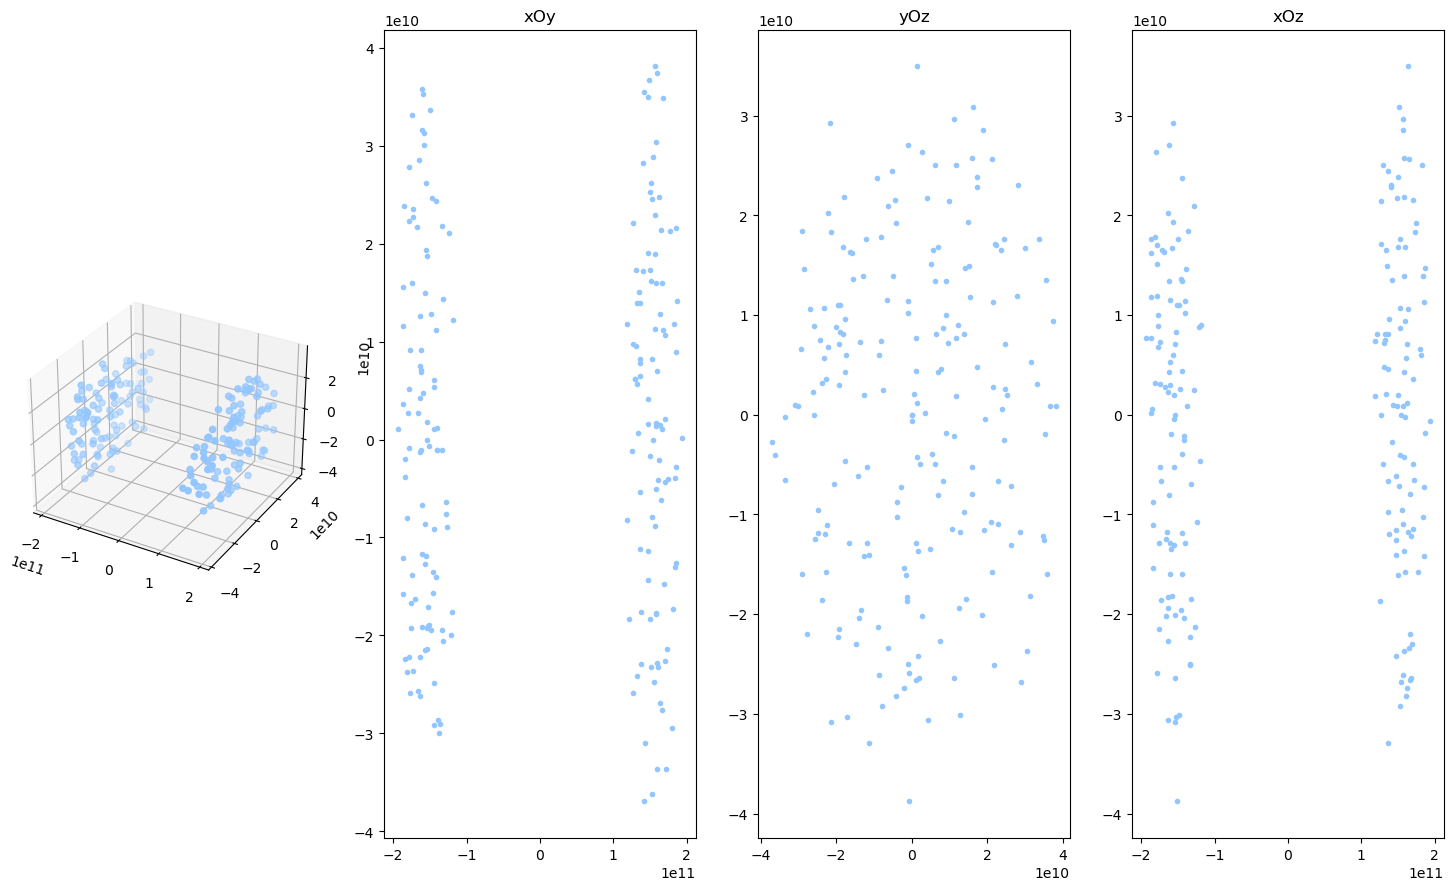

In [1114]:
figx = plt.figure()
figx.set_size_inches(18.5, 10.5)
axx = figx.add_subplot(141,projection='3d')
axx.scatter(pos[:,0],pos[:,1],pos[:,2])
axx2=figx.add_subplot(142,title="xOy")
axx2.plot(pos[:,0],pos[:,1],".")
axx3=figx.add_subplot(143,title="yOz")
axx3.plot(pos[:,1],pos[:,2],".")
axx4=figx.add_subplot(144,title="xOz")
axx4.plot(pos[:,0],pos[:,2],".")
plt.show()

In [1115]:
def getAcc( pos, mass, G, softening ):
  """
    Calculate the acceleration on each particle due to Newton's Law 
	pos  is an N x 3 matrix of positions
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	softening is the softening length
	a is N x 3 matrix of accelerations
	"""
	# positions r = [x,y,z] for all particles
  x = pos[:,0:1]
  y = pos[:,1:2]
  z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
  dx = x.T - x
  dy = y.T - y
  dz = z.T - z

	# matrix that stores 1/r^3 for all particle pairwise particle separations
  inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
  inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

  ax = G * (dx * inv_r3) @ mass
  ay = G * (dy * inv_r3) @ mass
  az = G * (dz * inv_r3) @ mass
	
	# pack together the acceleration components
  a = np.hstack((ax,ay,az))

  return a
acc=getAcc( pos, mass, G, softening )

In [1116]:
import numexpr as ne

In [975]:
50000/(dt/10**(7))

5000000.0

In [1118]:
N_T,dN_T,dN_T2,dN_T3 = 4000000,1000,10,500
#N_T,dN_T,dN_T2,dN_T3 =    10000,1,1,1
NinS=np.zeros((N_T//dN_T3+1))
pos_cm=pos[-1]
NinS[0]=len(np.delete(pos, np.where(np.sum((pos-pos_cm)**2,axis=1)>(R_cl)**2), axis = 0))


Ltot1=np.zeros((N_T//dN_T3+1))
Ltot1[0]=np.sqrt(np.sum(np.cross(pos[-2:],mass[-2:]*vel[-2:])**2))/(3.086*10**13)
Ltot2=np.zeros((N_T//dN_T3+1))
Ltot2[0]=np.sqrt(np.sum(np.cross(pos[:-2],mass[:-2]*vel[:-2])**2))/(3.086*10**13)


def NinShell(inp,pos_cm): #    inp=pos_save[:,:,1]
	pos_in_shell=np.delete(inp, np.where(np.sum((inp-pos_cm)**2,axis=1)>(R_cl)**2), axis = 0)
	return len(pos_in_shell)

# calculate initial gravitational accelerations
  
# number of timesteps
#Nt = int(np.ceil(tEnd/dt))
  
# save energies, particle orbits for plotting trails
pos_save = np.zeros((N,3,N_T//dN_T+1))
pos_save[:,:,0] = pos
#t_all = np.arange(N_T//dN_T+1)*d
# t

In [1119]:

def devour():

    return 
x = pos[:,0:1]
y = pos[:,1:2]
z = pos[:,2:3]
dx = x.T - x
dy = y.T - y
dz = z.T - z


inv_r3 = ne.evaluate("dx*dx + dy*dy + dz*dz + softening*softening")
inv_r3_coal=np.where(inv_r3[-2:,:]-softening*softening<softening_M*softening_M)
inv_r3_coal=(inv_r3_coal[0]+(N-2),inv_r3_coal[1])
inv_r3_coal

np.shape(inv_r3[inv_r3>softening*softening])

(40602,)

In [1120]:


# Simulation Main Loop
for i in trange(N_T):
    #vel -= np.mean(mass * vel,0) / np.mean(mass)
    # (1/2) kick
    vel += acc * dt/2.0
    # drift
    pos += vel * dt
    # update accelerations

    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = ne.evaluate("dx*dx + dy*dy + dz*dz + softening*softening") # softening - for halo particles
    #check your distance parameter (if it is too big, than there would be calculation problems)

    #inv_r3_coal=inv_r3[inv_r3==softening*softening]
    inv_r3_pos=inv_r3[inv_r3>softening*softening]
    inv_r3[inv_r3>softening*softening] = ne.evaluate("inv_r3_pos**(-1.5)")

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass
    
    # pack together the acceleration components
    acc = np.hstack((ax,ay,az))
  
    # (1/2) kick
    vel += acc * dt/2.0
  
    # update time
    #t += dt
  
    # save positions
    pos_save[:,:,int(i//dN_T+1)] = pos
    # save N in R_cl
    NinS[int(i//dN_T3+1)] = NinShell(pos,pos[-1])
    # save total angular momentum of a system
    Ltot1[int(i//dN_T3+1)]=np.sqrt(np.sum(np.cross(pos[-2:],mass[-2:]*vel[-2:])**2))/(3.086*10**13)
    Ltot2[int(i//dN_T3+1)]=np.sqrt(np.sum(np.cross(pos[:-2],mass[:-2]*vel[:-2])**2))/(3.086*10**13)

100%|██████████| 4000000/4000000 [2:00:23<00:00, 553.74it/s]  


In [1121]:
t_ncl=np.linspace(0,len(Ltot1)*dt*dN_T3*10**(-10),len(Ltot1))
#T_e/(dt*len(NinS)*dN_T3)

In [501]:
"""
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**2+b*x+c
def func2(x, a):
    return a+0*x

popt, pcov = curve_fit(func, t_ncl, NinS)
popt
popt2, pcov = curve_fit(func2, t_ncl[t_ncl<2*10**12], NinS[:len(t_ncl[t_ncl<2*10**12])])
popt2
"""

array([95.62575])

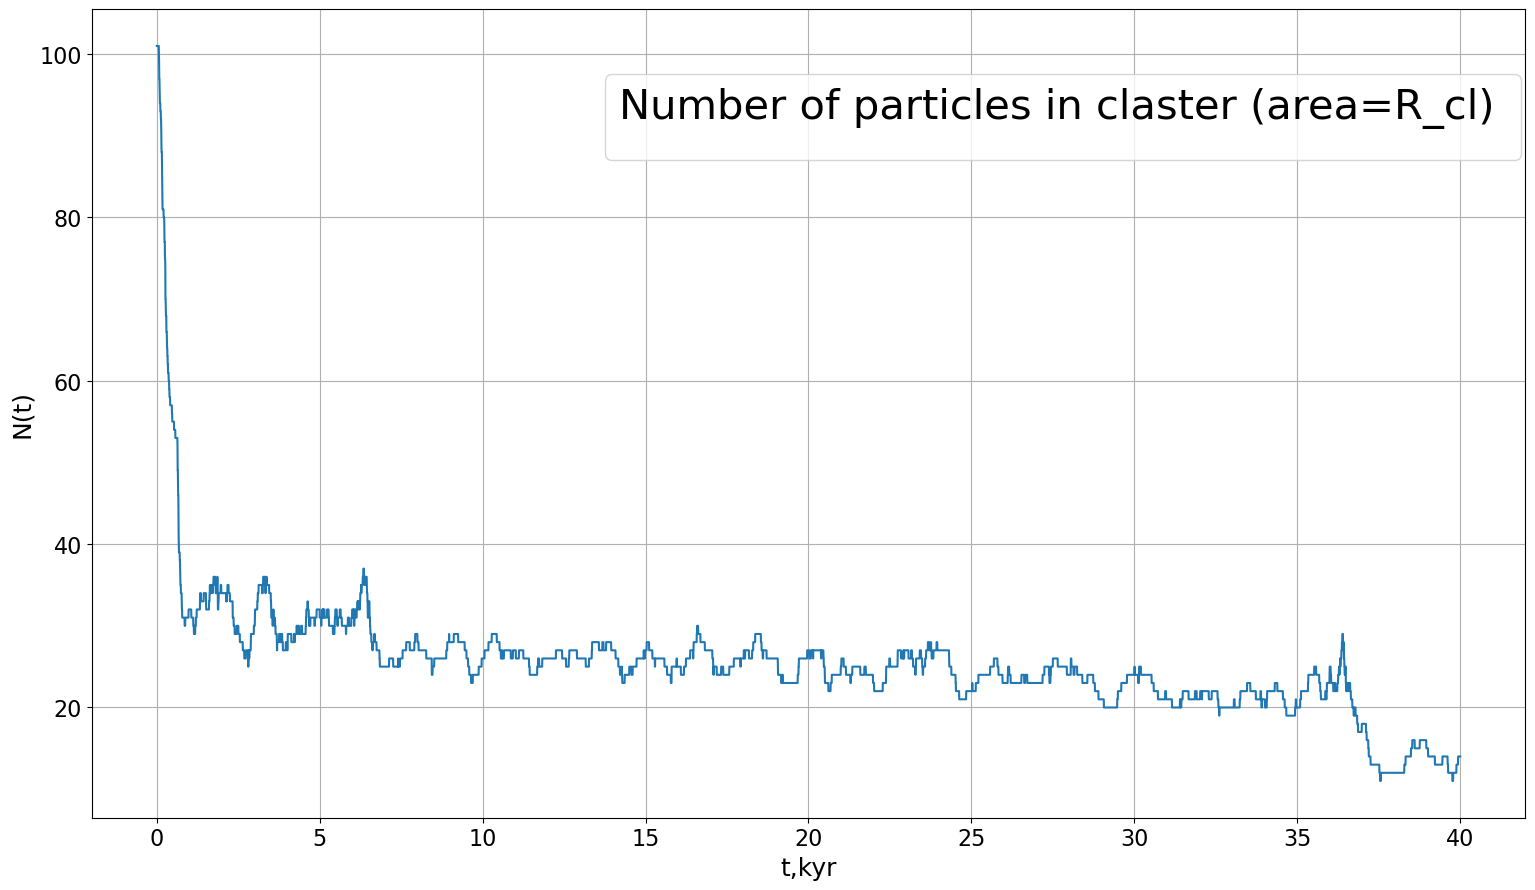

In [1122]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


fig3, ax3 = plt.subplots()

ax3.plot(t_ncl,NinS,color="tab:blue")#,markevery=100,label="data"
#ax3.plot(t_ncl, func(t_ncl, *popt), 'r-',
#         label=f'fit poly(2): a={popt[0]:.2}, b={popt[1]:.2}, c={popt[2]:.2}',linewidth= 3 )
#ax3.plot(t_ncl[t_ncl<2*10**12], func2(t_ncl[t_ncl<2*10**12], *popt2), '--',color="orange",
#         label=f'fit poly(0): a={popt2[0]:.2f}, t<2e+12',linewidth= 3 )

#ax3.plot(x, np.exp(np.sin(x)), label="exp(sin(x))",color="r")
#ax3.plot(x,Lagr1(x,x1,y1), label="N_5",linestyle="dashed",color="g")#[Lagr1_old(i,x1,y1) for i in x])
#ax3.plot(x,Lagr1(x,x2,y2), label="N_6",linestyle="dashed",color="tab:blue")#[Lagr1_old(i,x2,y2) for i in x])

ax3.set(xlabel='t,kyr', ylabel='N(t)')
ax3.xaxis.label.set_fontsize(18)
ax3.yaxis.label.set_fontsize(18)
ax3.tick_params(labelsize=16)
ax3.grid(True)

#ax3.set_ylim(0, 5)
#ax3.set_xlim(0, 5*dt/10**(10))
fig3.set_size_inches(18.5, 10.5)
lines = []
labels = []

for ax3 in fig3.axes:
    axLine, axLabel = ax3.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
fig3.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.65 , 0.72 ),title = 'Number of particles in claster (area=R_cl) ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
fig3 = ax3.get_figure()
fig3.savefig('Nt_graf.png')

plt.show()

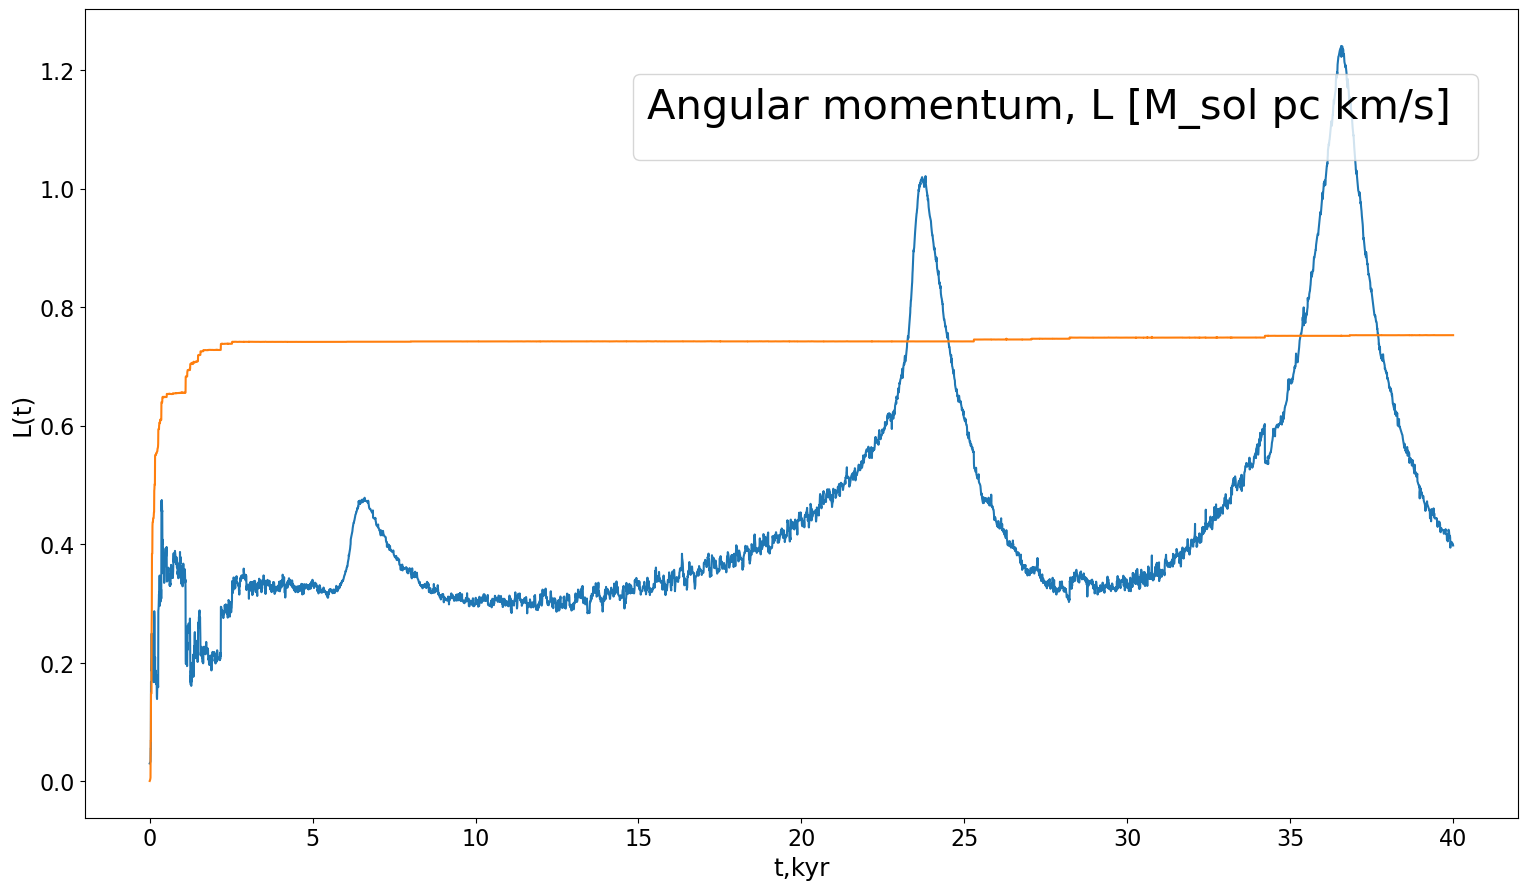

In [1123]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


figL, axL = plt.subplots()

axL.plot(t_ncl,Ltot1,color="tab:blue")#,markevery=100
axL.plot(t_ncl,Ltot2,color="tab:orange")
#axL.plot(t_ncl, func(t_ncl, *popt), 'r-', label=f'fit poly(2): a={popt[0]:.2}, b={popt[1]:.2}, c={popt[2]:.2}',linewidth= 3 )
#axL.plot(t_ncl[t_ncl<2*10**12], func2(t_ncl[t_ncl<2*10**12], *popt2), '--',color="orange", label=f'fit poly(0): a={popt2[0]:.2f}, t<2e+12',linewidth= 3 )

#ax3.plot(x, np.exp(np.sin(x)), label="exp(sin(x))",color="r")
#ax3.plot(x,Lagr1(x,x1,y1), label="N_5",linestyle="dashed",color="g")#[Lagr1_old(i,x1,y1) for i in x])
#ax3.plot(x,Lagr1(x,x2,y2), label="N_6",linestyle="dashed",color="tab:blue")#[Lagr1_old(i,x2,y2) for i in x])

axL.set(xlabel='t,kyr', ylabel='L(t)')
axL.xaxis.label.set_fontsize(18)
axL.yaxis.label.set_fontsize(18)
axL.tick_params(labelsize=16)
#axL.grid(True)
#ax3.set_ylim(1, 3);
figL.set_size_inches(18.5, 10.5)
lines = []
labels = []

for axL in figL.axes:
    axLine, axLabel = axL.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
figL.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.65 , 0.72 ),title = 'Angular momentum, L [M_sol pc km/s] ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
figL = axL.get_figure()
figL.savefig('Lt_graf.png')

plt.show()

In [1134]:
Rt=np.sum(np.sqrt(np.sum(pos_save[-2:,:,:]**2,axis=1)),axis=0)/(3.086*10**13)
t_r=np.linspace(0,len(Rt)*dt*dN_T/10**(10),len(Rt))

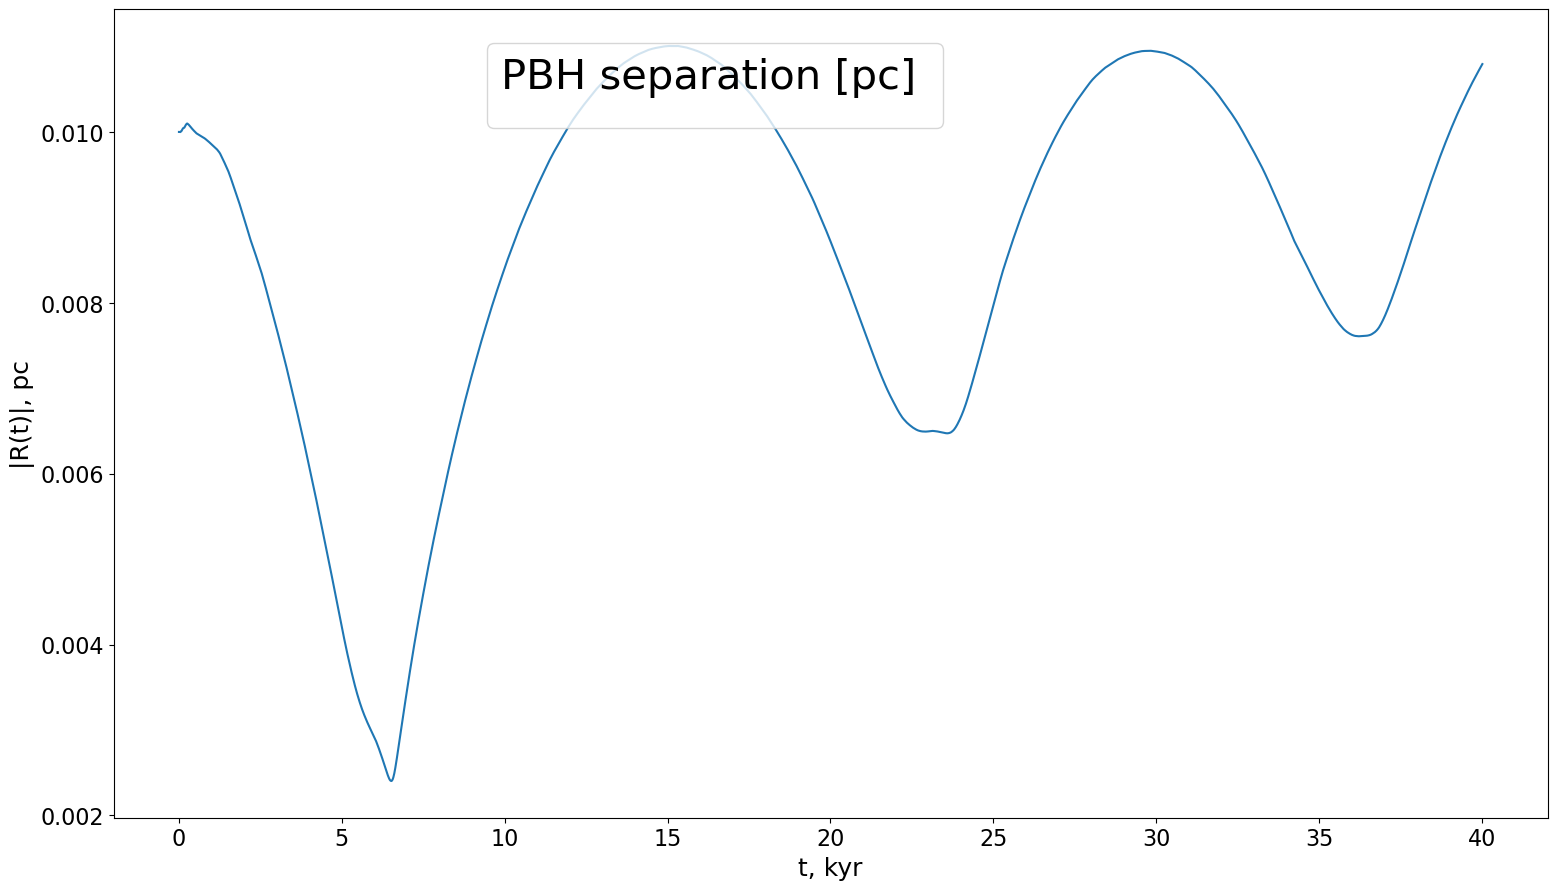

In [1135]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


figL, axL = plt.subplots()

axL.plot(t_r,Rt,color="tab:blue",markevery=10)#,markevery=100
#axL.plot(t_ncl, func(t_ncl, *popt), 'r-', label=f'fit poly(2): a={popt[0]:.2}, b={popt[1]:.2}, c={popt[2]:.2}',linewidth= 3 )
#axL.plot(t_ncl[t_ncl<2*10**12], func2(t_ncl[t_ncl<2*10**12], *popt2), '--',color="orange", label=f'fit poly(0): a={popt2[0]:.2f}, t<2e+12',linewidth= 3 )

#ax3.plot(x, np.exp(np.sin(x)), label="exp(sin(x))",color="r")
#ax3.plot(x,Lagr1(x,x1,y1), label="N_5",linestyle="dashed",color="g")#[Lagr1_old(i,x1,y1) for i in x])
#ax3.plot(x,Lagr1(x,x2,y2), label="N_6",linestyle="dashed",color="tab:blue")#[Lagr1_old(i,x2,y2) for i in x])

axL.set(xlabel='t, kyr', ylabel='|R(t)|, pc')
axL.xaxis.label.set_fontsize(18)
axL.yaxis.label.set_fontsize(18)
axL.tick_params(labelsize=16)
#axL.grid(True)
#ax3.set_ylim(1, 3);
#axL.set_xlim(4000*dt*10**(-10), 5000*dt*10**(-10));
figL.set_size_inches(18.5, 10.5)
lines = []
labels = []

for axL in figL.axes:
    axLine, axLabel = axL.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
figL.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.45 , 0.75 ),title = 'PBH separation [pc] ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
figL = axL.get_figure()
figL.savefig('pc_graf.png')

plt.show()

In [24]:
#!pip install py-heat-magic
#!pip install line_profiler

#!pip install py-heat-magic
#%load_ext heat

#%reload_ext line_profiler
#%lprun -f Modeling Modeling(N,pos,mass,G,softening,vel,dt,acc)

In [174]:
#N_T,dN_T,dN_T2 = 1000000,500,1

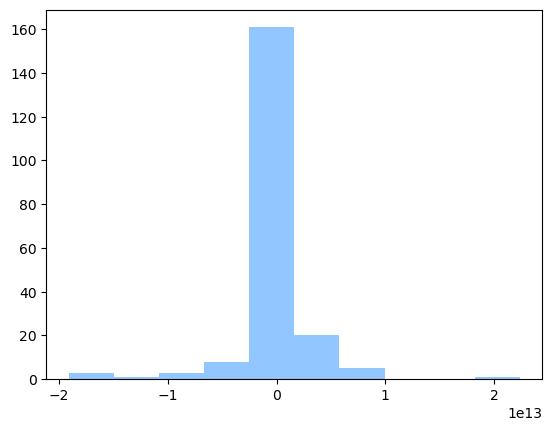

In [1126]:
np.sum(pos_save[:,0,1])/len(pos_save[:,0,1])
plt.hist(pos_save[:,2,200],bins=10)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_408/1279699061.py:8: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(-ppp, -ppp);


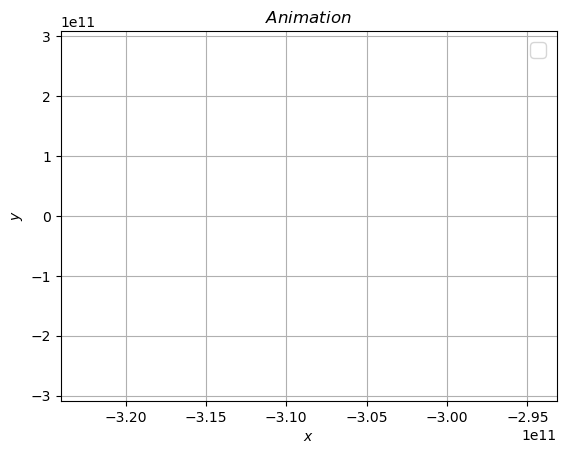

In [1127]:
i=0
figFF1, ax2 = plt.subplots()
ax2.grid(True)
ax2.legend(prop={'size': 15})
ax2.set(title = '$Animation$', xlabel='$x$', ylabel='$y$')
ppp=a*2
ax2.set_ylim(-ppp,ppp)
ax2.set_xlim(-ppp, -ppp);
ax2.scatter(pos_save[:-2,0,i],pos_save[:-2,1,i],s=5,color='tab:blue')
#ax2.scatter(np.mean(pos_save[:,0,i]),np.mean(pos_save[:,1,i]),s=10,color='tab:red')
ax2.scatter(pos_save[-2:,0,i],pos_save[-2:,1,i],s=10,color='tab:red')
plt.show()

In [1128]:
figFF, ax1 = plt.subplots()
ax1.grid(True)
ax1.legend(prop={'size': 15})
ax1.set(title = '$Animation$', xlabel='$x$', ylabel='$y$')
R_e=a
scale=10#10**3.
ax1.set_ylim(-scale*R_e, scale*R_e)
ax1.set_xlim(-scale*R_e, scale*R_e);
plt.ioff()
pbar = tqdm(total=N_T/dN_T2/dN_T)
#time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
#energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
#line_tail, = ax1.scatter(pos_save[:,0,max(i-50,0):],pos_save[:,1,max(i-50,0):],s=1,color=[.7,.7,1])
line = ax1.scatter(pos_save[:-2,0,0],pos_save[:-2,1,0],s=5,color='tab:blue')
line2 = ax1.scatter(pos_save[-2:,0,0],pos_save[-2:,1,0],s=10,color='tab:red')

#centre mass poin (it`s not change globaly, but actually you can see difference`)
#line2 = ax1.scatter(np.mean(pos_save[:,0,0]),np.mean(pos_save[:,1,0]),s=10,color='tab:green')  

#line, = ax1.plot([], [], 'bo', ms=6)
#line_tail1, = ax1.plot([],[], 'bo', ms=2,color="lightpink")#[.7,.7,1])
#line_tail2, = ax1.plot([],[], 'bo', ms=2,color="wheat")#[.7,.7,1])
    #time_text.set_text('time = %.1f' % i)
    #energy_text.set_text('energy = %.3f J' % KE_save[i]+PE_save[i])

for i in range(0,int(N_T/dN_T),dN_T2):
  #line_tail1.set_data((pos_save[-2,0,0:i+1:30],pos_save[-2,1,0:i+1:30]))#max(i-1500,0)
  #line_tail2.set_data((pos_save[-1,0,0:i+1:30],pos_save[-1,1,0:i+1:30]))#max(i-1500,0)
  # data =  #x[:i,np.newaxis], y[:i, np.newaxis]
  line.set_offsets(np.vstack((pos_save[:-2,0,i+1],pos_save[:-2,1,i+1])).T)
  line2.set_offsets(np.vstack((pos_save[-2:,0,i+1],pos_save[-2:,1,i+1])).T)

  #centre mass poin (it`s not change globaly, but actually you can see difference`)
  #line2.set_offsets(np.vstack((np.mean(pos_save[:,0,i+1],axis=0),np.mean(pos_save[:,1,i+1],axis=0))).T) 

  figFF = ax1.get_figure()
  figFF.savefig('Pic_t/saved_figure_'+str(i)+'.png')
  plt.close(figFF)
  plt.clf()
  pbar.update(1)
pbar.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 400/400.0 [00:21<00:00, 18.25it/s]


In [1129]:
from PIL import Image
 
# Список для хранения кадров.
frames = []
 
for frame_number in trange(0, int(N_T/dN_T),dN_T2):
    # Открываем изображение каждого кадра.
    frame = Image.open(f'Pic_t/saved_figure_{frame_number}.png')
    # Добавляем кадр в список с кадрами.
    frames.append(frame)
    
# Берем первый кадр и в него добавляем оставшееся кадры.
frames[0].save(
    'homer2.gif',
    save_all=True,
    append_images=frames[1:],  # Срез который игнорирует первый кадр.
    optimize=True,
    duration=1,
    loop=0
)

100%|██████████| 400/400 [00:00<00:00, 969.19it/s] 


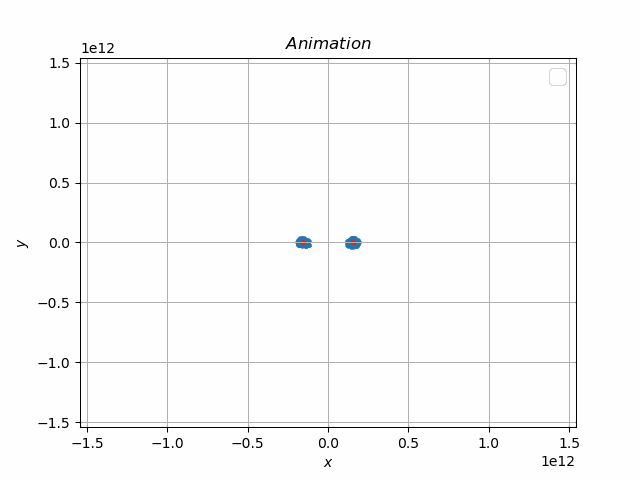

In [1130]:
from IPython.display import Image
Image('homer2.gif')

In [1136]:
# save and load massive in binary file https://pyprog.pro/file_input_and_output.html
#np.save('example_1', NinS)
np.savez_compressed('3_1x2N202dte5add30x2_001', Ltot1=Ltot1,Ltot2=Ltot2, NinS=NinS, vel=vel, pos_save=pos_save)
#a = np.load('example_1.npy')

In [ ]:
v_e= G* (30+30+2*100*m)*(1-e)/(a*(1+e))

In [1141]:
1-0.14*a/(G* (30+30+2*3.1)),a/(1+1-0.14*a/(G* (30+30+2*3.1)))/(3.086*10**13)

(0.9975362537764351, 0.002503083481237083)

In [ ]:
class particle:
    def __init__(self):
        self.pos=pos